## Setup

In [1]:
# use full window width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import numpy as np
os.chdir('..')
import virl
from matplotlib import pyplot as plt

import pandas as pd
from IPython import display


def smooth_plot(all_rewards, smoothed_rewards,title): 
    plt.figure(2, figsize=(12, 6))
    plt.clf()
    plt.title(title)
    plt.xlabel("Epsiode") 
    plt.ylabel("Total Reward")
    plt.plot(all_rewards, '--', alpha=0.5) 
    plt.plot(smoothed_rewards) 
    plt.legend(["Rewards", "Rewards (Smoothed)"]) 
    
   # display.clear_output(wait=True)

## Agent Implementation

In [2]:
class QTable:
    def __init__(self, initial, num_of_actions):
        self.q_table = {}
        self.initial = initial
        self.num_of_actions = num_of_actions
    
    def get_actions(self, state):
        state_tuple = tuple(state)
        return self.q_table.get(state_tuple, [self.initial]*self.num_of_actions)
    
    def get_action_value(self, state, action_index):
        state_tuple = tuple(state)
        return self.q_table.get(state_tuple, [self.initial]*self.num_of_actions)[action_index]
    
    def set_action_value(self, state, action_index, action_value):
        if not tuple(state) in self.q_table:
            self.q_table[tuple(state)] = [self.initial]*self.num_of_actions
        self.q_table[tuple(state)][action_index] = action_value 

class QLearningAgent:

    def __init__(self, env):
        self.num_of_actions = env.action_space.n
        self.env = env

        self.q_table = QTable(initial=0, num_of_actions=self.num_of_actions) 
        
        # hyper parameters
        self.discount = 0.99 # gamma
        self.learning_rate = 0.25 # step size, alpha
        self.episodes = 1500
        self.print_out_every_x_episodes = int(self.episodes/50)
        
        # hyper parameters for epsilon
        self.initial_epsilon = 1 # initial
        self.decrease_factor = (1/self.episodes)/1.25 # epsilon
        self.decrease_factor = 0.00075
        
        # hyper parameters for discretising state data
        self.highest = 600000000
        self.lowest = 0
        self.number_bins = 20
        
        print("Hyperparameter dump")
        print("----")
        print("Number Of Episodes = " + str(self.episodes))
        print("Print out every " + str(self.print_out_every_x_episodes) + " episodes")
        print("Learning Rate = " + str(self.learning_rate))
        print("Discount = " + str(self.discount))
        print("----")
        print("Initial Epsilon = " + str(self.initial_epsilon))
        print("Epsilon Decrease Factor = " + str(self.decrease_factor))
        print("----")
        print("Number of Bins to Discretise State = " + str(self.number_bins))
        print("----")
        
    def continous_to_discrete(self,continous_state):
        bins = np.linspace(self.lowest,self.highest,num=self.number_bins)
        discrete = np.digitize(continous_state,bins)
        return discrete
    
    
    def train(self):
        states,all_rewards, all_total_rewards = self.run_all_episodes("Training")
        return states,all_rewards, all_total_rewards

    
    def evaluate(self,episodes=100):
        self.episodes = episodes
        self.epsilon = -1000
        states,all_rewards, all_total_rewards = self.run_all_episodes("Evaluation")
        return states,all_rewards, all_total_rewards
    
    
    def run_all_episodes(self,title):
        all_total_rewards = []
        all_rewards = []
        all_q_table_exploits = []
        epislon = self.initial_epsilon # at the start only explore
        
        for episode in range(1, self.episodes + 1):
            rewards, exploited_q_table, states= self.run_episode(epislon)
            total_reward = np.sum(rewards)

#             if episode % self.print_out_every_x_episodes == 0:
#                 print("Episode number: " + str(episode) + ". Total reward in episode: " + str(total_reward) + ". Episode executed with epsilon = " + str(epislon))
#                 print("Average total reward in last " + str(self.print_out_every_x_episodes) + " episodes: " + str(np.mean(all_rewards[-self.print_out_every_x_episodes:])))
#                 print("Average number of times we exploited q table in last " + str(self.print_out_every_x_episodes) + " episodes: " + str(np.mean(all_q_table_exploits[-self.print_out_every_x_episodes:])))
#                 print("-----")
            all_total_rewards.append(total_reward)
            all_rewards.append(rewards)
            all_q_table_exploits.append(exploited_q_table)
            epislon -= self.decrease_factor #hyperparameter
        
        #graph with orange smoothed reward
        window_size = int(self.episodes/10)
        smoothed_rewards = pd.Series(all_total_rewards).rolling(window_size, min_periods=window_size).mean() 
        this_smoothed_reward = smoothed_rewards.values[-1]
        smooth_plot(all_total_rewards, smoothed_rewards,title)
        return states,all_rewards, all_total_rewards
    
    def run_episode(self,epislon):
        rewards = []
        states = []
        done = False
        
        state = self.env.reset()
        states.append(state)
        state = self.continous_to_discrete(state)
        
        exploited_q_table = 0
        
        while not done:
            random_number = np.random.random()
            if random_number < epislon:
                #explore
                action = np.random.choice(self.num_of_actions)
            else:
                #exploit
                action = self.get_action(state)
                exploited_q_table+=1
                
            new_state, reward, done, i = self.env.step(action=action) # Q-learning
            states.append(new_state)

            new_state = self.continous_to_discrete(new_state)
            
            #update q table
            self.update_q_table(state,new_state,action,reward)
            
            rewards.append(reward)
            state = new_state
        return (rewards, exploited_q_table, states)
    
    def update_q_table(self,state,new_state,action,reward):
        #target
        #max of a' given the 
        max_a_prime = np.max(self.q_table.get_actions(new_state))
        target = reward + (self.discount*max_a_prime)
        
        #compute difference
        action_value = self.q_table.get_action_value(state,action)
        difference = target - action_value
        
        #take a small step in the delta direction
        new_q = action_value + (self.learning_rate * difference)
        
        self.q_table.set_action_value(state,action,new_q)
        
    
    def get_action(self,state):
        #exploit the q table
        actions = self.q_table.get_actions(state)
        action = np.argmax(self.q_table.get_actions(state))
        return action

## Train

In [3]:
def plot(state,agent, total_rewards, rewards,title):
    fig, axes = plt.subplots(1, 4, figsize=(40, 16))
    labels = ['s[0]: susceptibles', 's[1]: infectious', 's[2]: quarantined', 's[3]: recovereds']
    states = np.array(state)
    for i in range(4):
        axes[0].plot(states[:,i], label=labels[i]);
        
    axes[0].set_xlabel(title + 'weeks since start of epidemic')
    axes[0].set_ylabel('State s(t)')
    axes[0].legend()
    axes[0].title.set_text('Final state')
    
   
    axes[1].plot(total_rewards);
    axes[1].set_xlabel('episode number')
    axes[1].set_ylabel('total reward r(t)')
    axes[1].title.set_text('Total reward per episode')


    axes[2].plot(rewards[0]);
    axes[2].set_xlabel('episode number')
    axes[2].set_ylabel('total reward r(t)')
    axes[2].title.set_text('First Episode reward')
    
   
    axes[3].plot(rewards[-1]);
    axes[3].set_xlabel('episode number')
    axes[3].set_ylabel('total reward r(t)')
    axes[3].title.set_text('Final Episode reward')

In [4]:
print("stochastic=False, noisy=False")

env = virl.Epidemic(stochastic=False, noisy=False)



stochastic=False, noisy=False


Problem id: 0

Hyperparameter dump
----
Number Of Episodes = 50
Print out every 1 episodes
Learning Rate = 0.25
Discount = 0.99
----
Initial Epsilon = 1
Epsilon Decrease Factor = 0.00075
----
Number of Bins to Discretise State = 20
----
Train


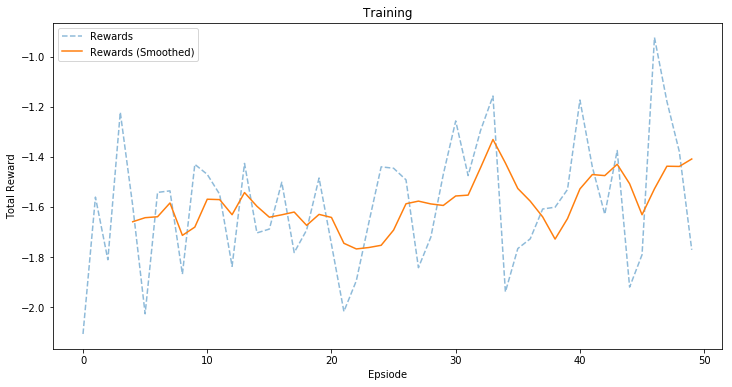

Evaluate


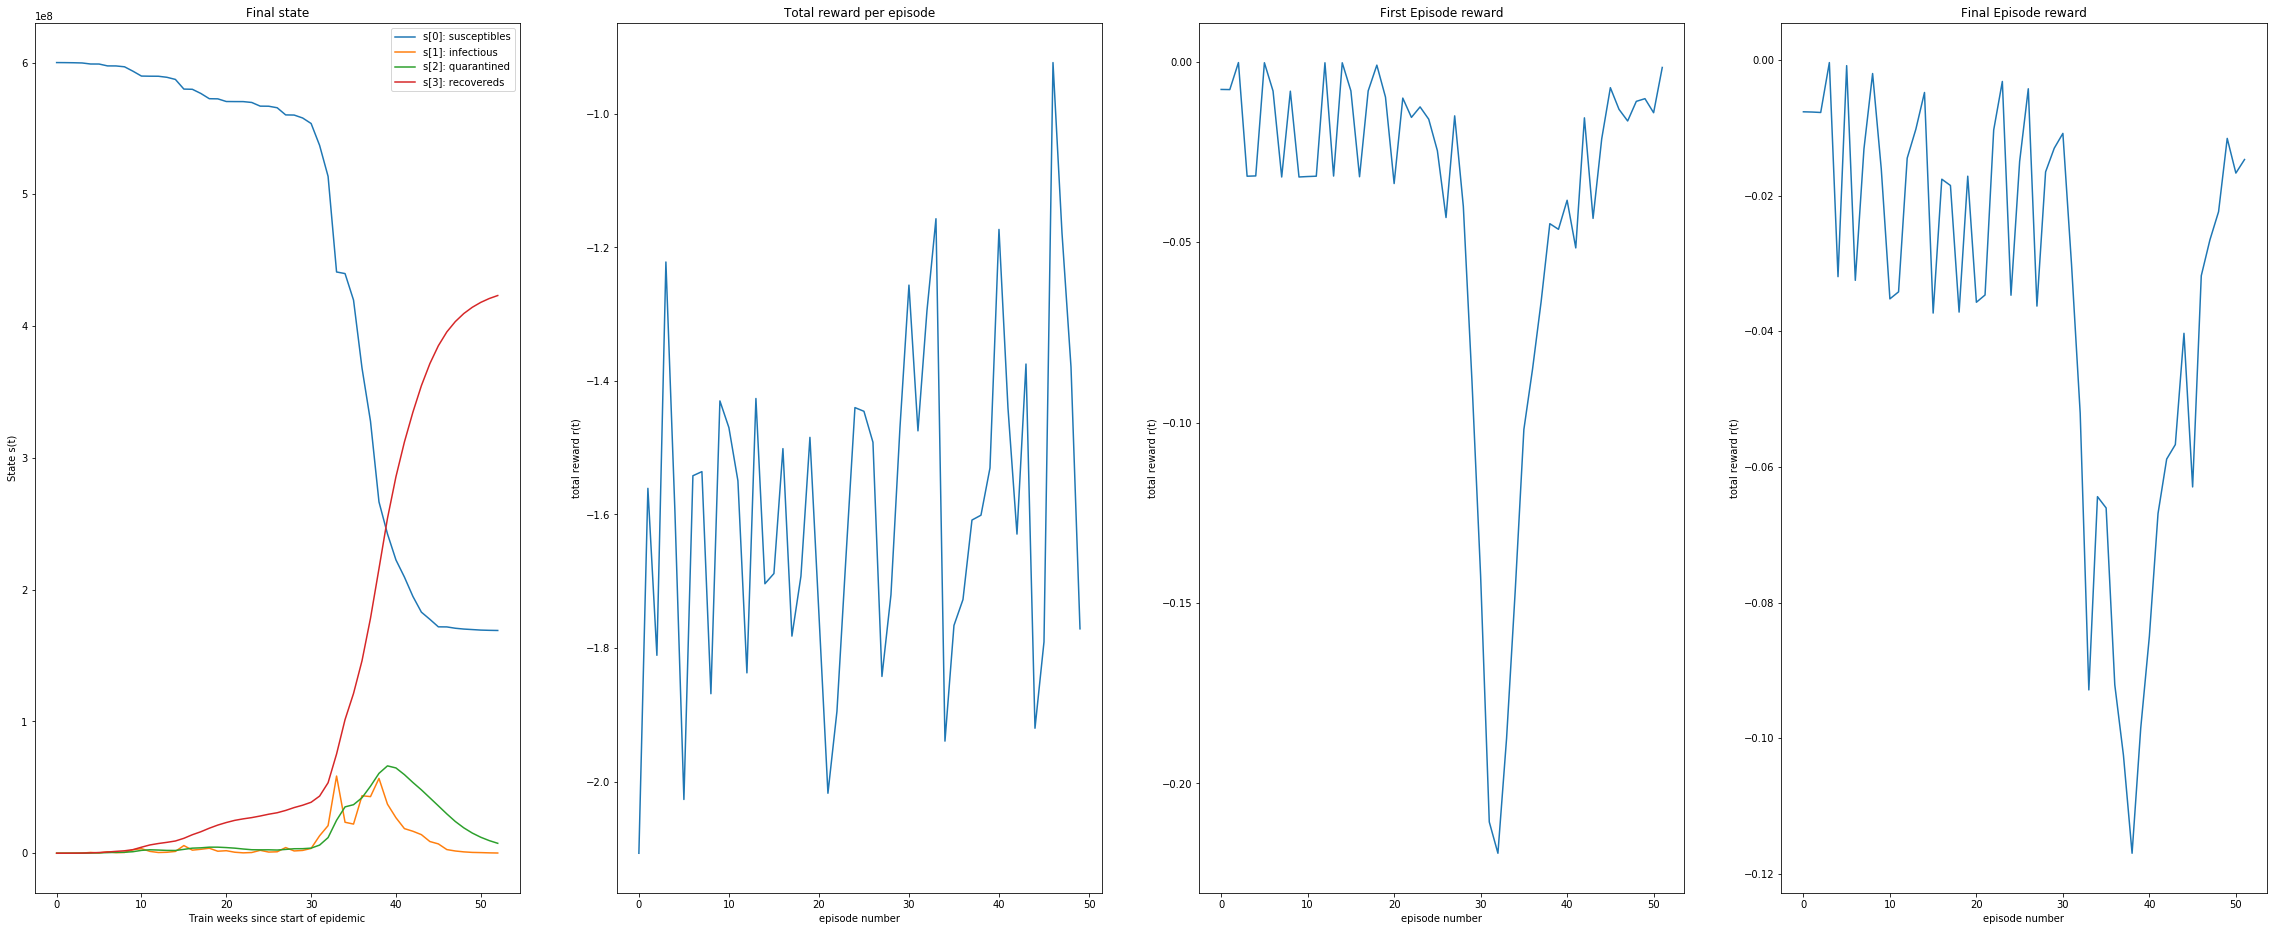

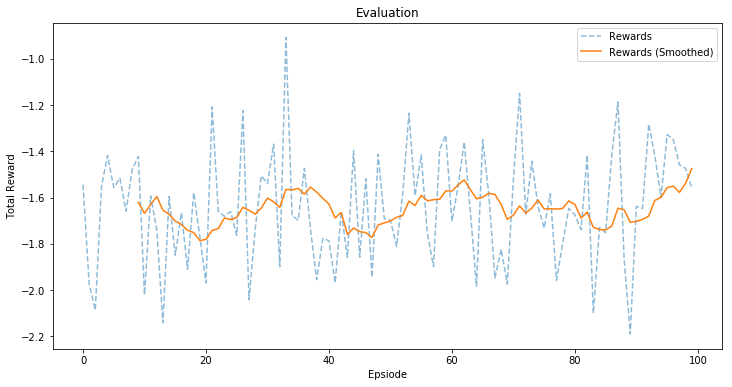

Problem id: 1

Hyperparameter dump
----
Number Of Episodes = 50
Print out every 1 episodes
Learning Rate = 0.25
Discount = 0.99
----
Initial Epsilon = 1
Epsilon Decrease Factor = 0.00075
----
Number of Bins to Discretise State = 20
----
Train


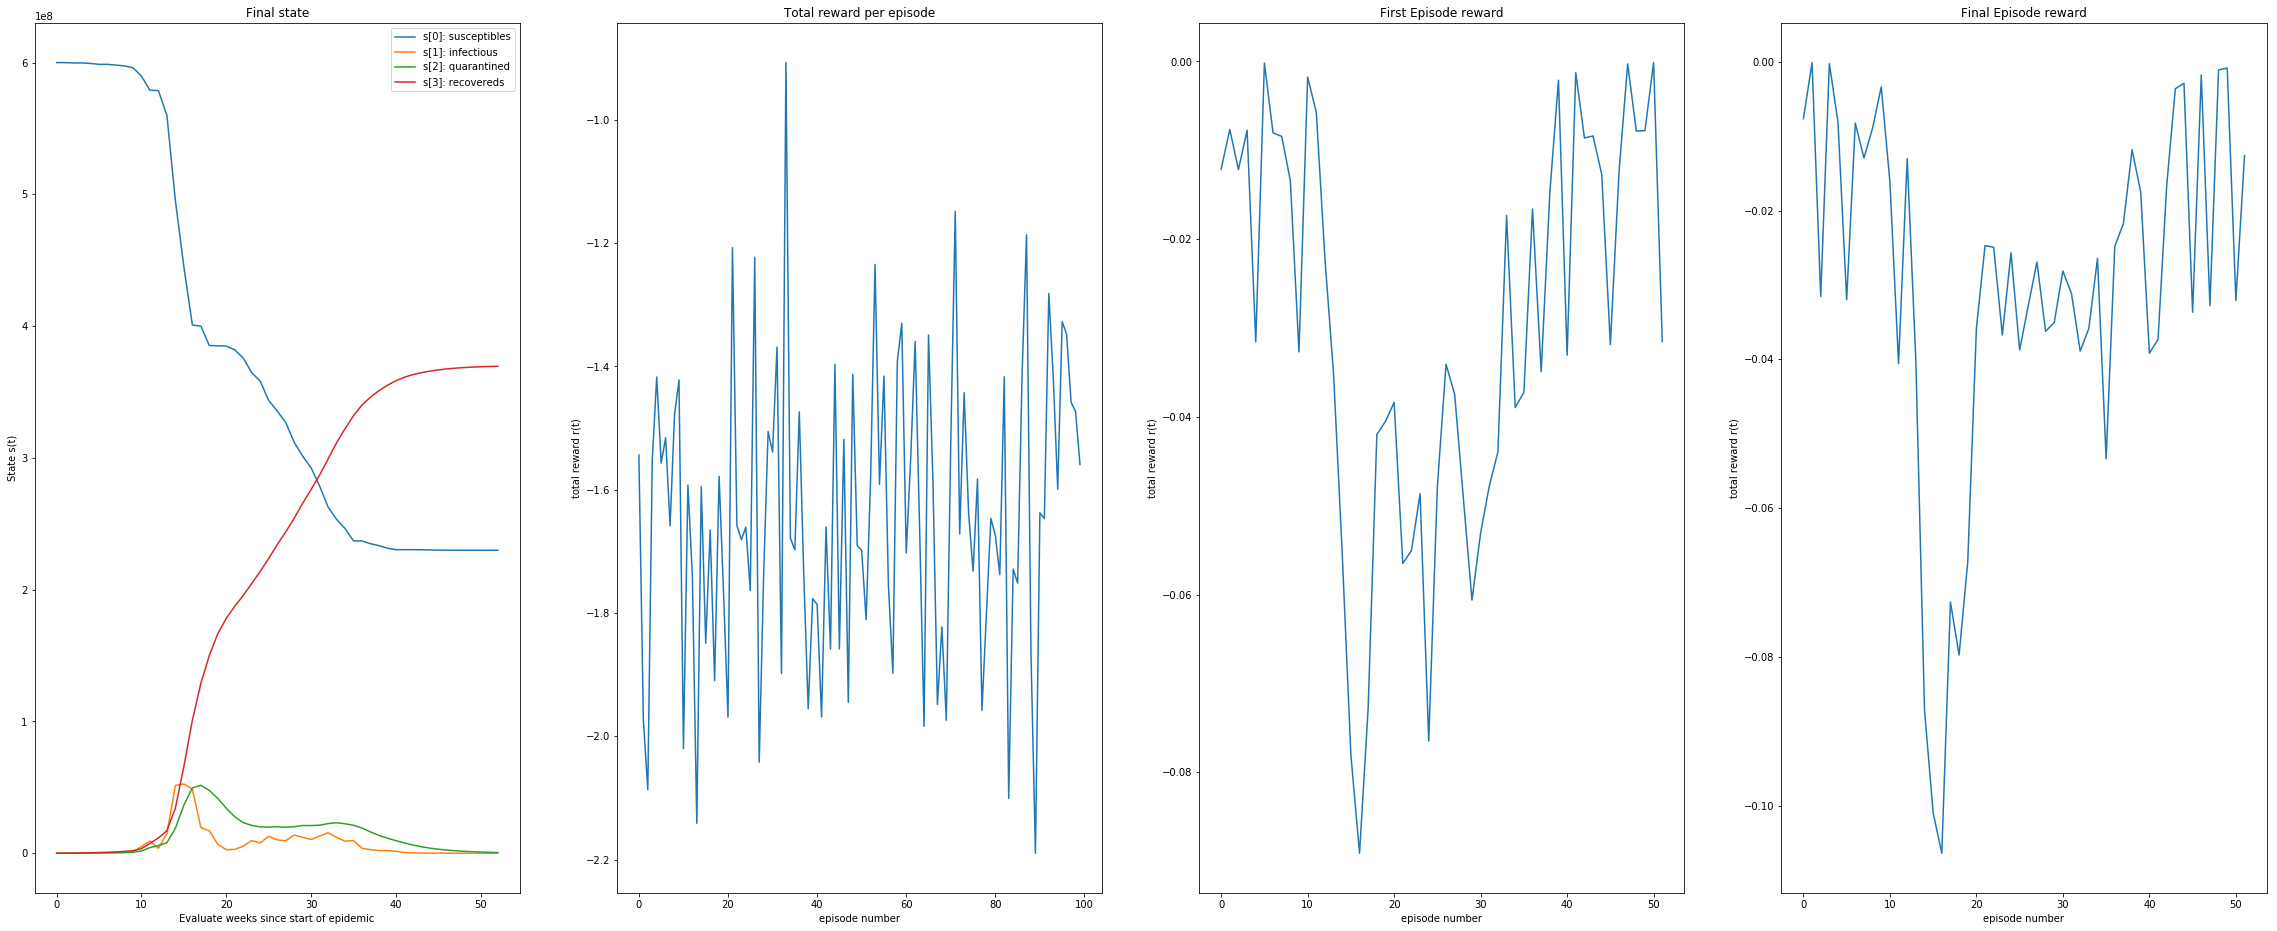

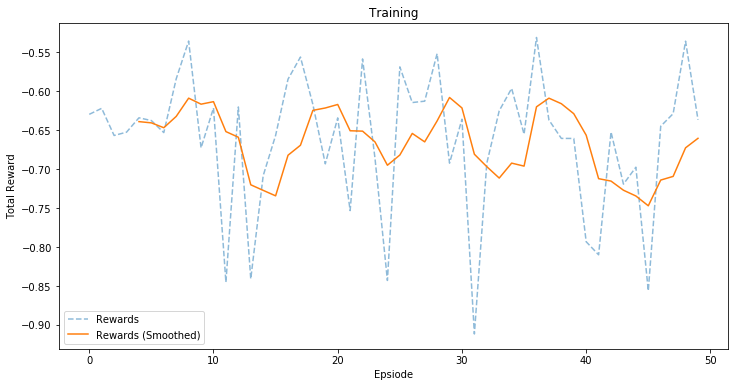

Evaluate


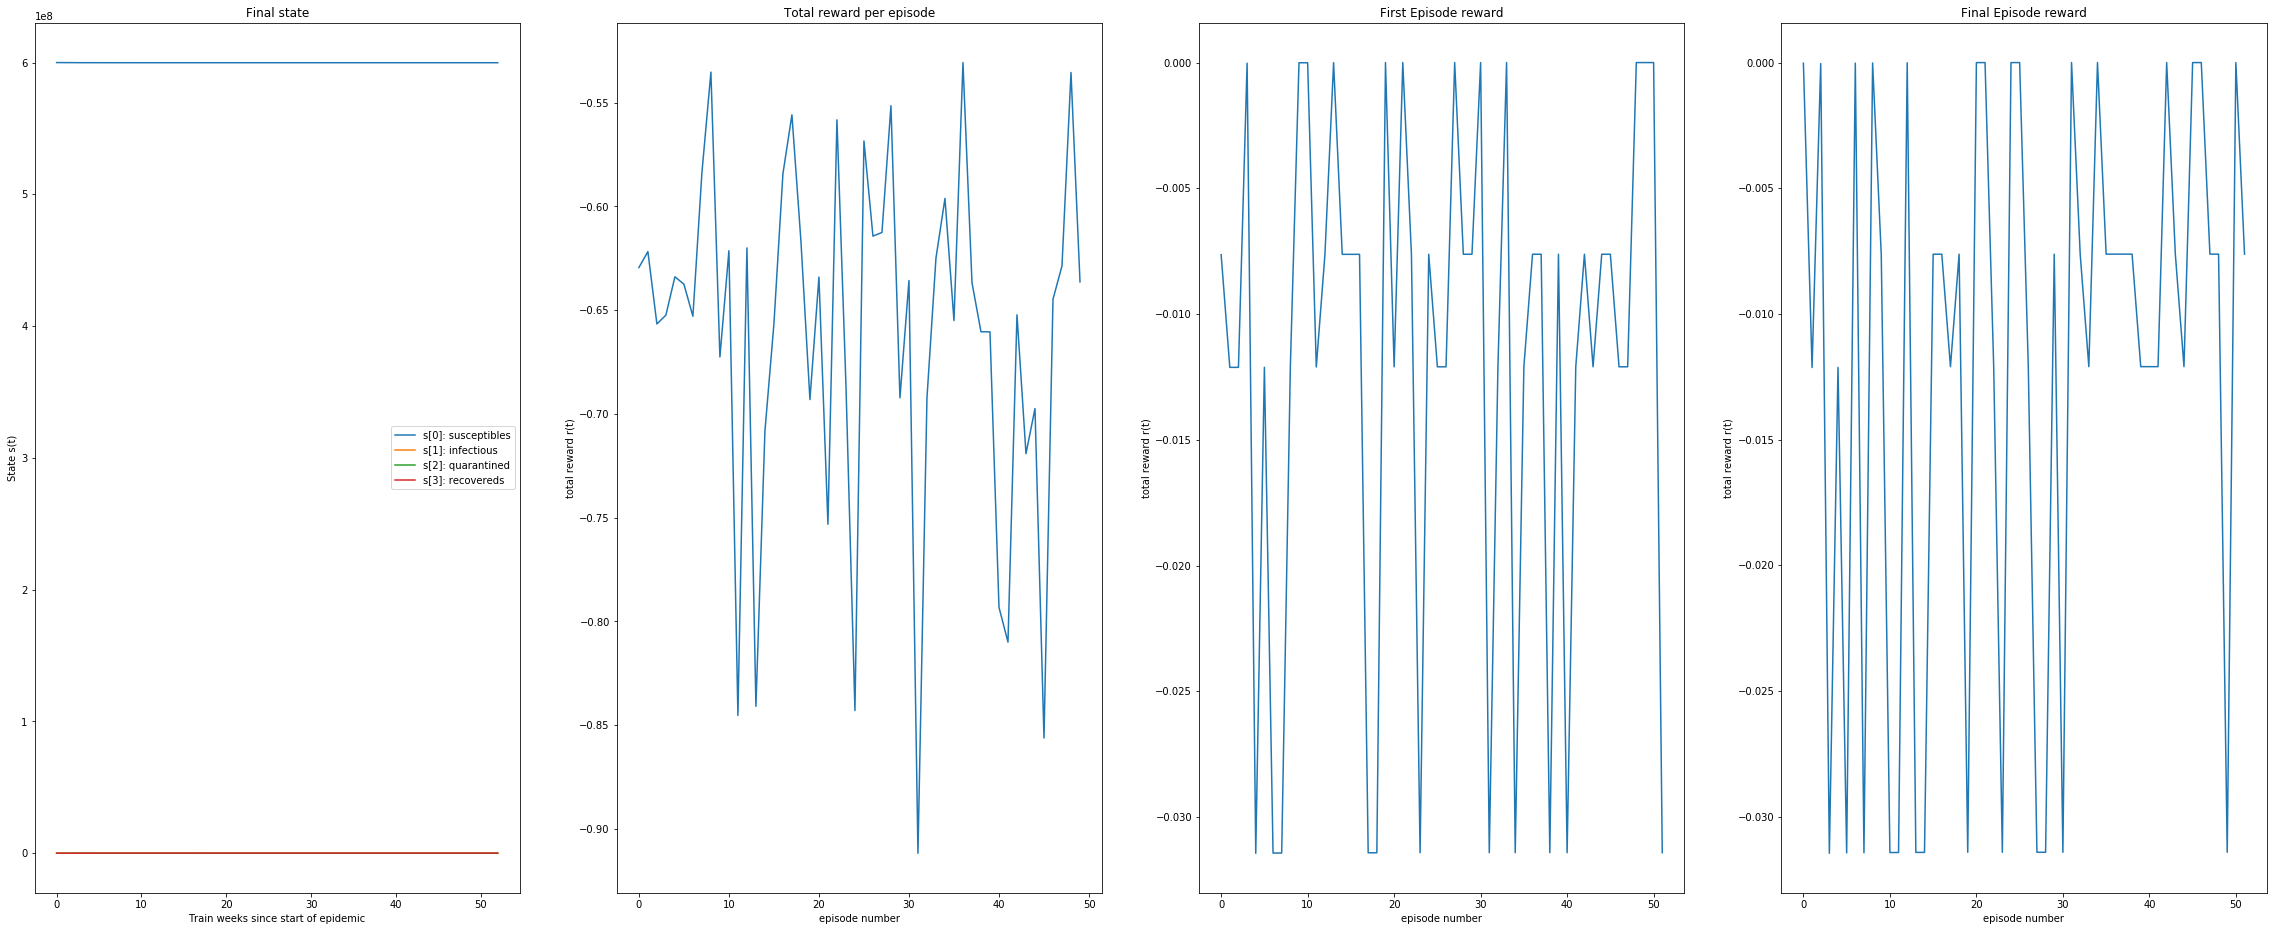

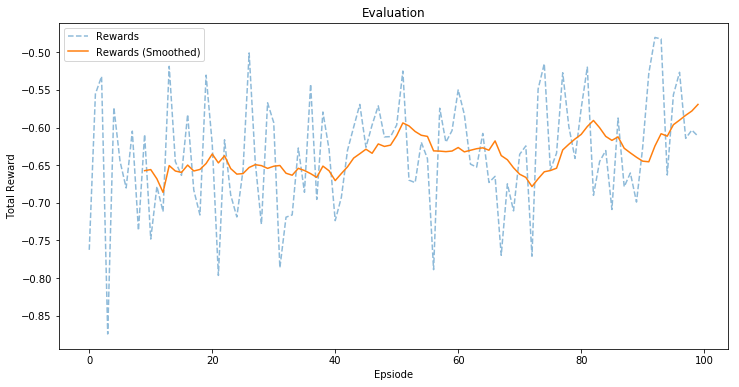

Problem id: 2

Hyperparameter dump
----
Number Of Episodes = 50
Print out every 1 episodes
Learning Rate = 0.25
Discount = 0.99
----
Initial Epsilon = 1
Epsilon Decrease Factor = 0.00075
----
Number of Bins to Discretise State = 20
----
Train


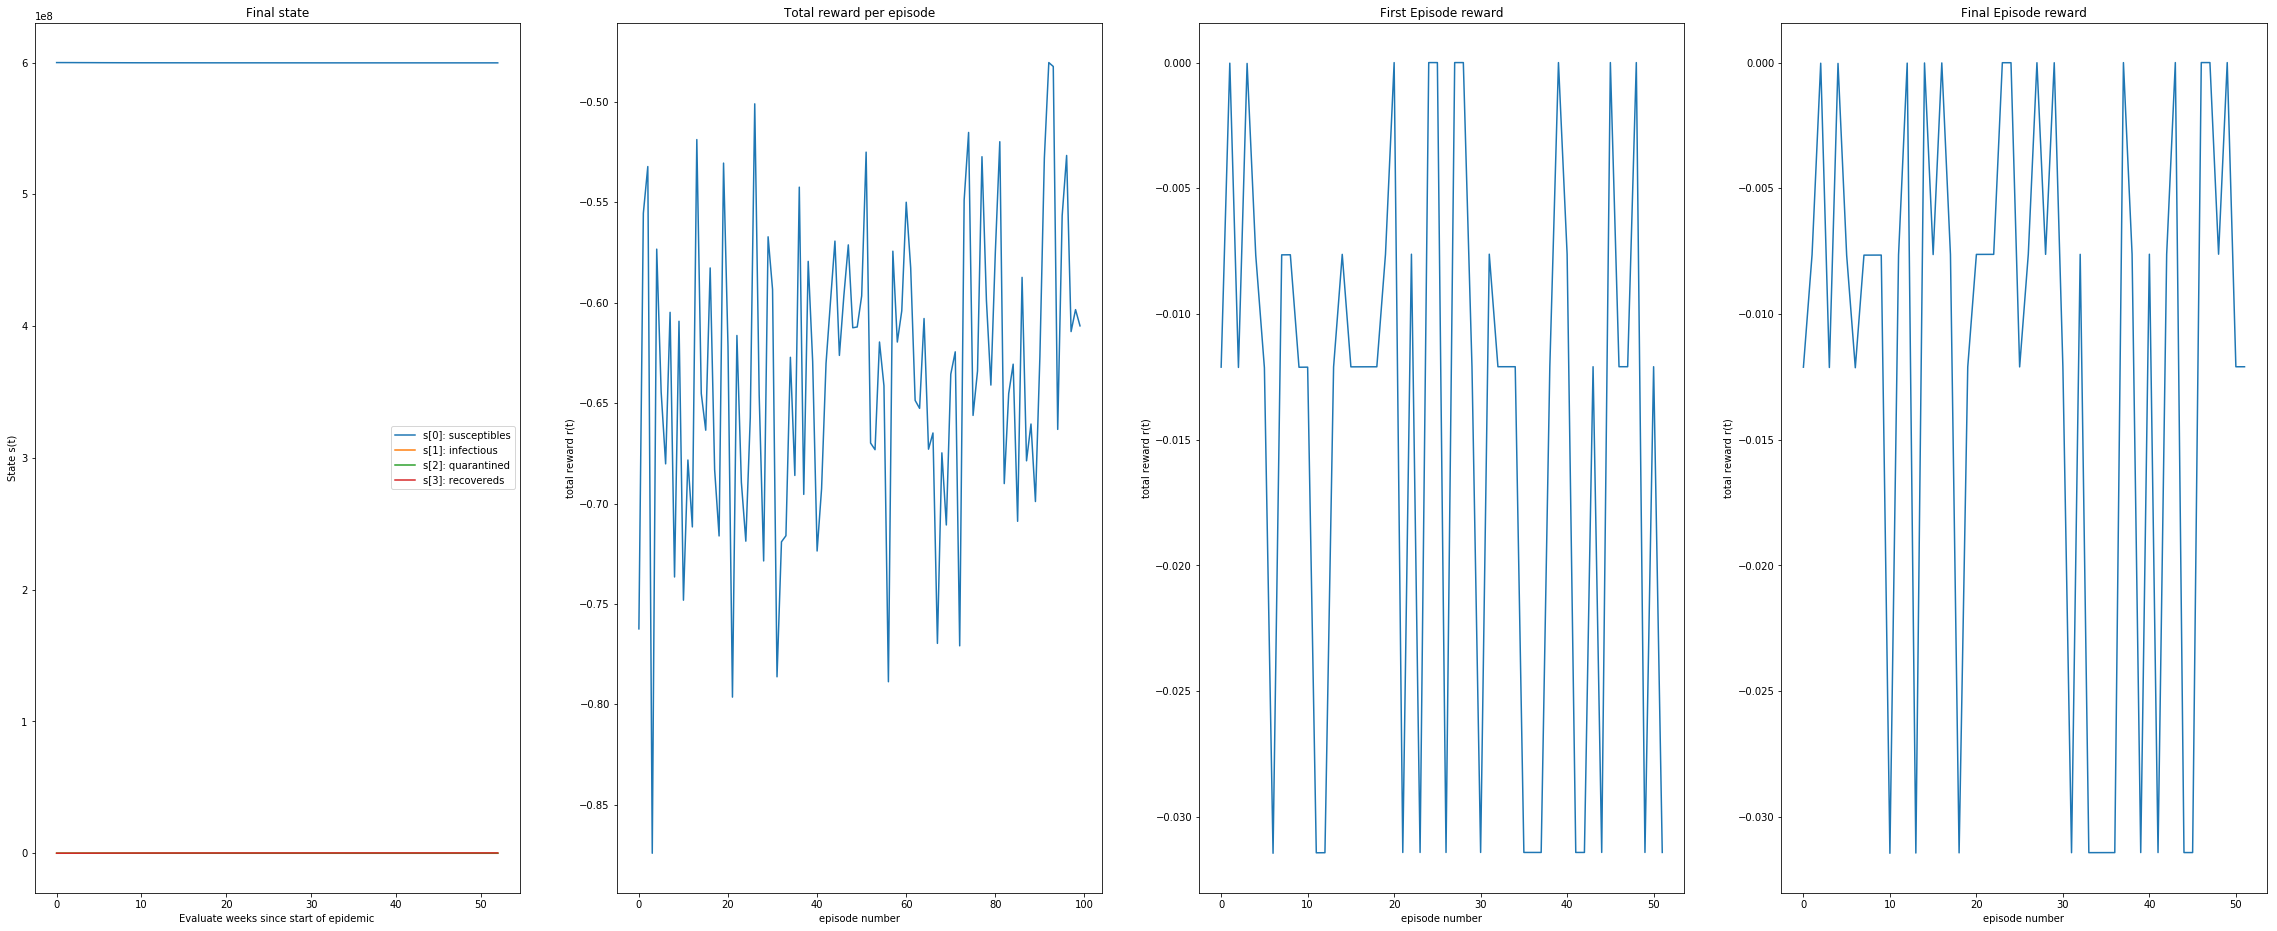

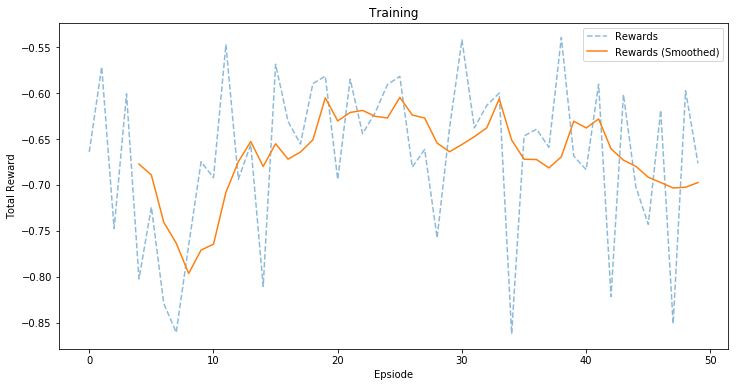

Evaluate


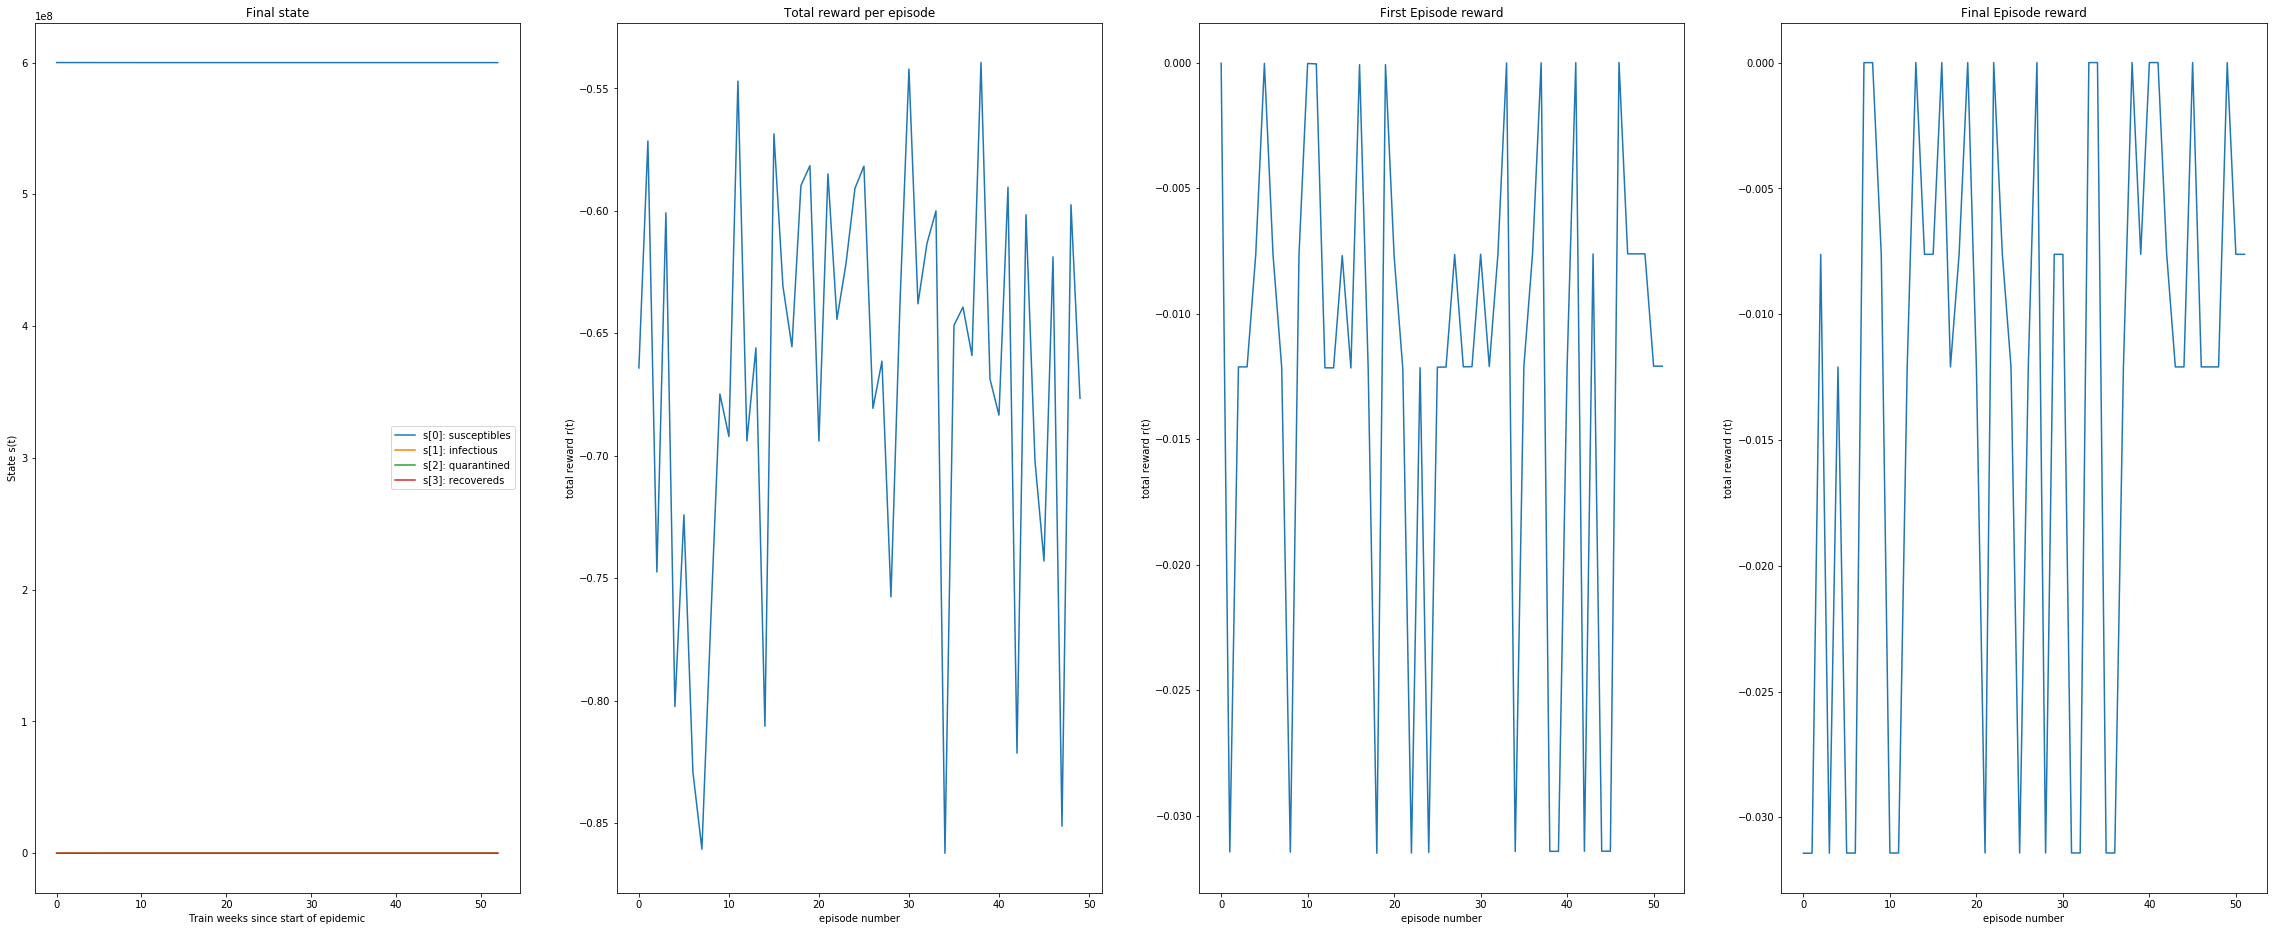

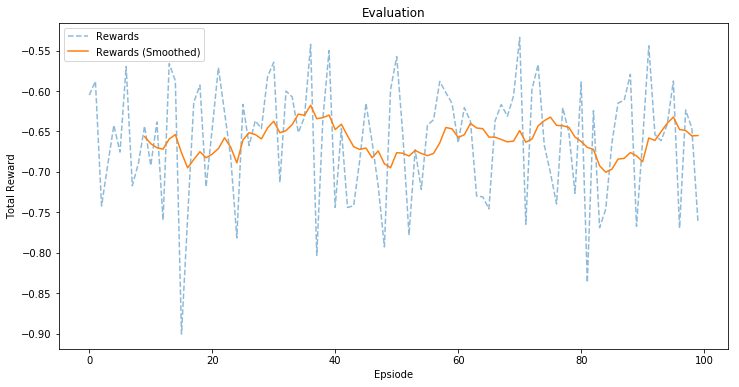

Problem id: 3

Hyperparameter dump
----
Number Of Episodes = 50
Print out every 1 episodes
Learning Rate = 0.25
Discount = 0.99
----
Initial Epsilon = 1
Epsilon Decrease Factor = 0.00075
----
Number of Bins to Discretise State = 20
----
Train


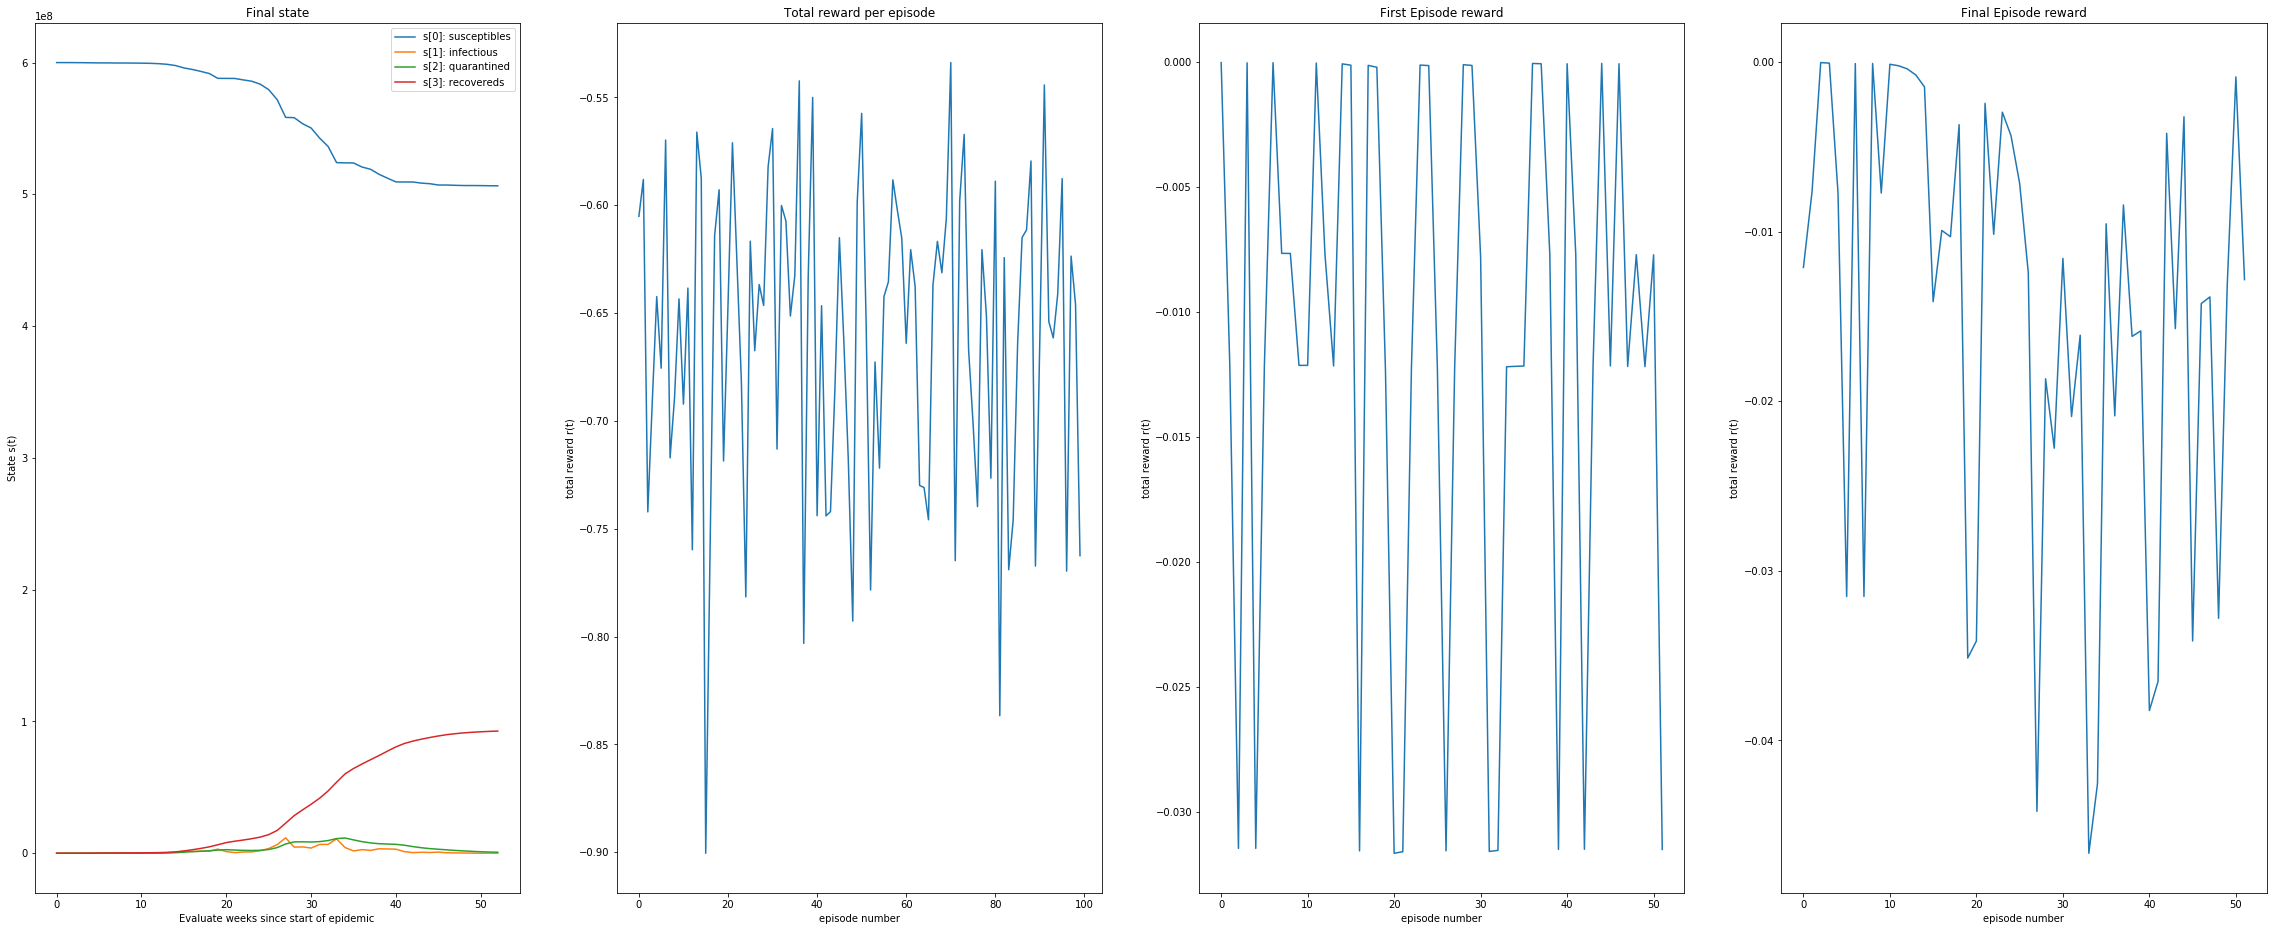

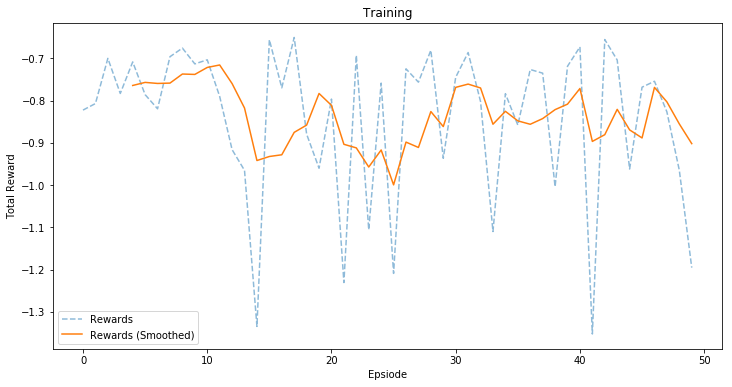

Evaluate


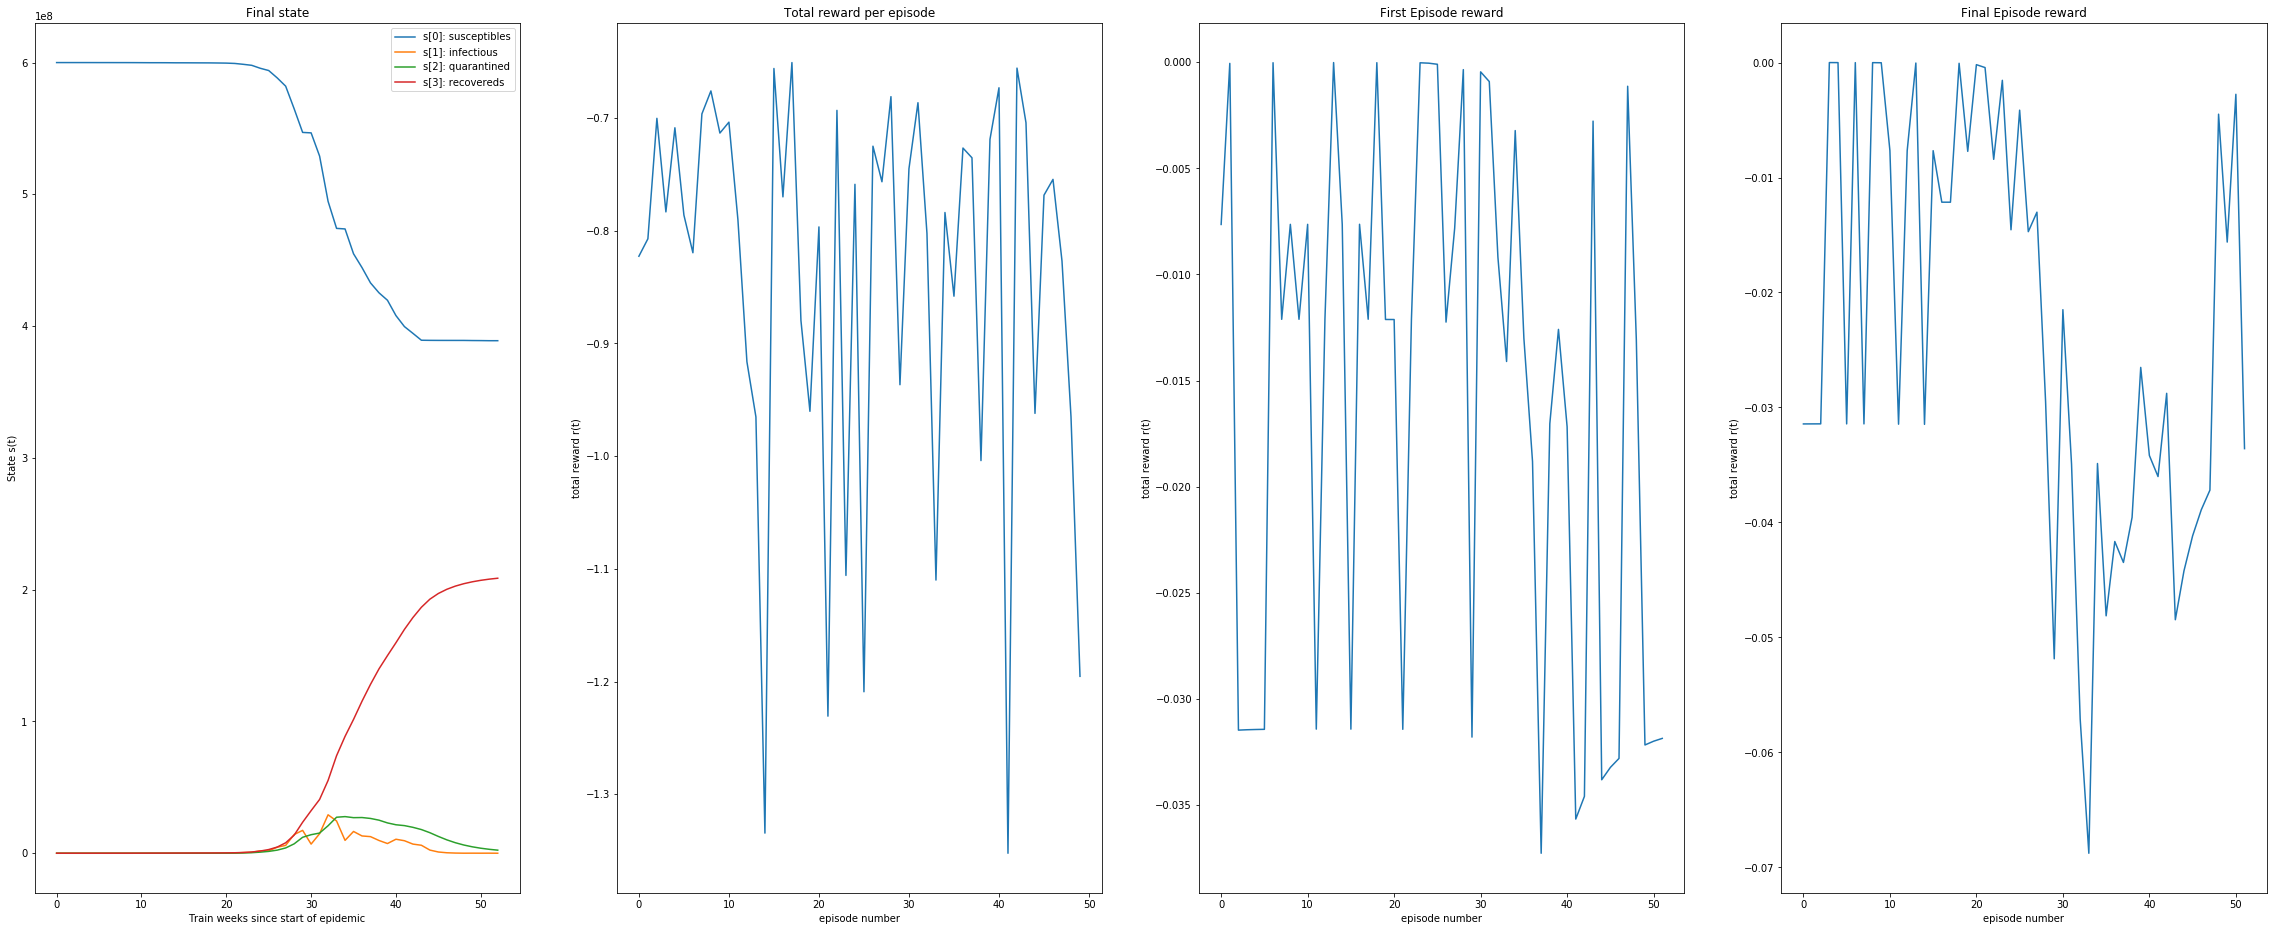

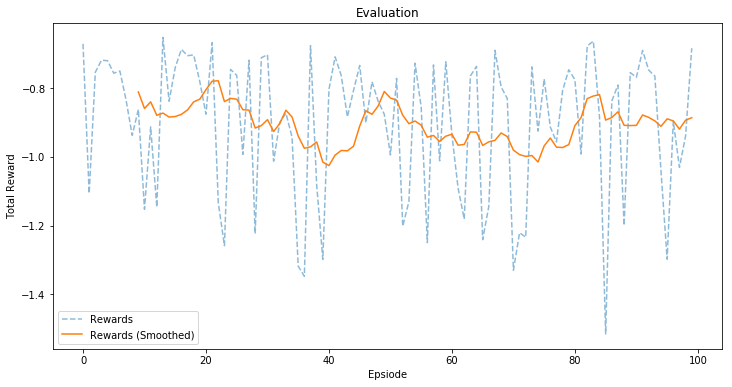

Problem id: 4

Hyperparameter dump
----
Number Of Episodes = 50
Print out every 1 episodes
Learning Rate = 0.25
Discount = 0.99
----
Initial Epsilon = 1
Epsilon Decrease Factor = 0.00075
----
Number of Bins to Discretise State = 20
----
Train


In [ ]:
#change the problem id

for i in range(0,10):
    print("Problem id: " + str(i))
    print()
    env = virl.Epidemic(stochastic=False, noisy=False,problem_id=i)
    agent = QLearningAgent(env)
    
    print("Train")
    states,all_rewards, all_total_rewards = agent.train()
    plot(states,agent, all_total_rewards, all_rewards,"Train ")

    print("Evaluate")

    states,all_rewards, all_total_rewards = agent.evaluate()
    plot(states,agent, all_total_rewards, all_rewards,"Evaluate ")

In [ ]:
#chnage stochastic and noisy
stochastic_noisy = {0:virl.Epidemic(stochastic=False, noisy=False),1:virl.Epidemic(stochastic=True, noisy=False),2:virl.Epidemic(stochastic=False, noisy=True),3:virl.Epidemic(stochastic=True, noisy=True)}

for i in range(0,4):
    
    env = stochastic_noisy[i] 
    agent = QLearningAgent(env)
    
    
    print("Train")
    states,all_rewards, all_total_rewards = agent.train()
    plot(states,agent, all_total_rewards, all_rewards,"Train ")

    print("Evaluate")
    states,all_rewards, all_total_rewards = agent.evaluate()
    plot(states,agent, all_total_rewards, all_rewards,"Evaluate ")


## Evaluation

Eval here